In [1]:
import pandas as pd
import requests
import pickle
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import sys
#from config import keys

import re
import gensim
from nltk.stem import WordNetLemmatizer

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, auc, average_precision_score, confusion_matrix, roc_auc_score
from tqdm import tqdm
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
df = pd.read_csv("labeled_data.csv", index_col=0)
df.head()

count  hate_speech  offensive_language  neither  class  \
0      3            0                   0        3      2   
1      3            0                   3        0      1   
2      3            0                   3        0      1   
3      3            0                   2        1      1   
4      6            0                   6        0      1   

                                               tweet  
0  !!! RT @mayasolovely: As a woman you shouldn't...  
1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...  
2  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...  
3  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...  
4  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [77]:
df = df.drop(columns=['count', 'hate_speech', 'offensive_language', 'neither'], axis=1)
df.columns = ['label', 'text']
df.label.value_counts()

1    19190
2     4163
0     1430
Name: label, dtype: int64

In [78]:
df = df.replace({'label': {1: 1, 2: 0, 0: 1}})
df.label.value_counts()

1    20620
0     4163
Name: label, dtype: int64

In [79]:
df.head()

label                                               text
0      0  !!! RT @mayasolovely: As a woman you shouldn't...
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [80]:
df1 = pd.read_csv('toxicity_en.csv')
df1

text   is_toxic
0    Elon Musk is a piece of shit, greedy capitalis...      Toxic
1    The senile credit card shrill from Delaware ne...      Toxic
2    He does that a lot -- makes everyone look good...      Toxic
3                                           F*ck Lizzo      Toxic
4    Epstein and trump were best buds!!! Pedophiles...      Toxic
..                                                 ...        ...
995  My maternal abuelita taught me how to make pla...  Not Toxic
996  Funnily enough I was looking online last week ...  Not Toxic
997  I can't bear how nice this is.\n \n I guess it...  Not Toxic
998  Going to buy a share of Tesla just to ensure i...  Not Toxic
999  I only saw a couple of these throughout the mo...  Not Toxic

[1000 rows x 2 columns]

In [81]:
df1.columns=['text','label']
df1

text      label
0    Elon Musk is a piece of shit, greedy capitalis...      Toxic
1    The senile credit card shrill from Delaware ne...      Toxic
2    He does that a lot -- makes everyone look good...      Toxic
3                                           F*ck Lizzo      Toxic
4    Epstein and trump were best buds!!! Pedophiles...      Toxic
..                                                 ...        ...
995  My maternal abuelita taught me how to make pla...  Not Toxic
996  Funnily enough I was looking online last week ...  Not Toxic
997  I can't bear how nice this is.\n \n I guess it...  Not Toxic
998  Going to buy a share of Tesla just to ensure i...  Not Toxic
999  I only saw a couple of these throughout the mo...  Not Toxic

[1000 rows x 2 columns]

In [82]:
df1.label.value_counts()

Toxic        501
Not Toxic    499
Name: label, dtype: int64

In [83]:
dum = pd.get_dummies(df1.label, drop_first=True)
dum

Toxic
0        1
1        1
2        1
3        1
4        1
..     ...
995      0
996      0
997      0
998      0
999      0

[1000 rows x 1 columns]

In [84]:
df1 = df1.drop('label', axis=1)
df1 = pd.concat([df1,dum], axis=1)
df1.columns=['text','label']
df1

text  label
0    Elon Musk is a piece of shit, greedy capitalis...      1
1    The senile credit card shrill from Delaware ne...      1
2    He does that a lot -- makes everyone look good...      1
3                                           F*ck Lizzo      1
4    Epstein and trump were best buds!!! Pedophiles...      1
..                                                 ...    ...
995  My maternal abuelita taught me how to make pla...      0
996  Funnily enough I was looking online last week ...      0
997  I can't bear how nice this is.\n \n I guess it...      0
998  Going to buy a share of Tesla just to ensure i...      0
999  I only saw a couple of these throughout the mo...      0

[1000 rows x 2 columns]

In [85]:
df2 = pd.read_csv('hs2_2021.csv')
df2

text  class
0      #DhoniKeepsTheGlove | WATCH: Sports Minister K...      0
1      @politico No. We should remember very clearly ...      1
2      @cricketworldcup Guess who would be the winner...      0
3      Corbyn is too politically intellectual for #Bo...      0
4      All the best to #TeamIndia for another swimmin...      0
...                                                  ...    ...
31783  RT @BreadTruckkBri: "@VoiceOfDStreetz: &#8220;...      1
31784  Selling ex lax brownies in front of Meijer to ...      0
31785  &#8220;@kaitlinfryer: Big oleeeee middle finge...      1
31786  &#8220;@iamkrause: All I see in every #IfTheyG...      0
31787  "@royalswagg_: using y=mx+b to find the slope ...      1

[31788 rows x 2 columns]

In [86]:
df2.columns=['text','label']
df2

text  label
0      #DhoniKeepsTheGlove | WATCH: Sports Minister K...      0
1      @politico No. We should remember very clearly ...      1
2      @cricketworldcup Guess who would be the winner...      0
3      Corbyn is too politically intellectual for #Bo...      0
4      All the best to #TeamIndia for another swimmin...      0
...                                                  ...    ...
31783  RT @BreadTruckkBri: "@VoiceOfDStreetz: &#8220;...      1
31784  Selling ex lax brownies in front of Meijer to ...      0
31785  &#8220;@kaitlinfryer: Big oleeeee middle finge...      1
31786  &#8220;@iamkrause: All I see in every #IfTheyG...      0
31787  "@royalswagg_: using y=mx+b to find the slope ...      1

[31788 rows x 2 columns]

In [87]:
df2['label'].value_counts()

1    23169
0     8619
Name: label, dtype: int64

In [91]:
combined = pd.concat([df, df1, df2], ignore_index=True)
combined.label.value_counts()

1    44290
0    13281
Name: label, dtype: int64

In [92]:
combined.head()

label                                               text
0      0  !!! RT @mayasolovely: As a woman you shouldn't...
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...

In [93]:
combined.tail()

label                                               text
57566      1  RT @BreadTruckkBri: "@VoiceOfDStreetz: &#8220;...
57567      0  Selling ex lax brownies in front of Meijer to ...
57568      1  &#8220;@kaitlinfryer: Big oleeeee middle finge...
57569      0  &#8220;@iamkrause: All I see in every #IfTheyG...
57570      1  "@royalswagg_: using y=mx+b to find the slope ...

In [94]:
# separate into hate and not-hate subsets
hate = combined[combined.label == 1]
not_hate = combined[combined.label == 0]

# separate into features and target for train_test_aplit
X_hate = hate.text
y_hate = hate.label
X_not_hate = not_hate.text
y_not_hate = not_hate.label

# perform 80-20 split on dataset
X_hate_tr, X_hate_val, y_hate_tr, y_hate_val = train_test_split(X_hate, y_hate, test_size=0.20, random_state=42)
X_not_hate_tr, X_not_hate_val, y_not_hate_tr, y_not_hate_val = train_test_split(X_not_hate, y_not_hate, test_size=0.20, random_state=42)

# concatenate to reform training and validation dataset
X_train = pd.concat((X_hate_tr, X_not_hate_tr), ignore_index=True)
y_train = pd.concat((y_hate_tr, y_not_hate_tr), ignore_index=True)
train = pd.concat([X_train, y_train], axis=1)

X_val = pd.concat((X_hate_val, X_not_hate_val), ignore_index=True)
y_val = pd.concat((y_hate_val, y_not_hate_val), ignore_index=True)
valid = pd.concat([X_val, y_val], axis=1)

In [95]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

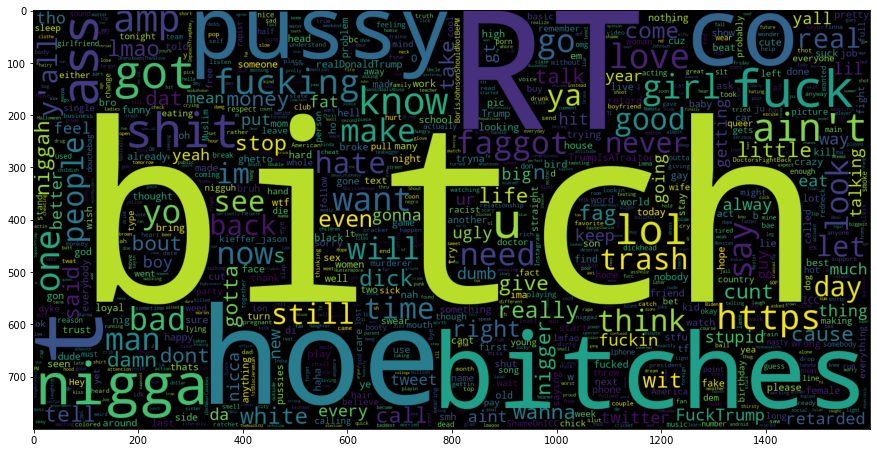

In [96]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(hate['text']))
plt.imshow(wc)

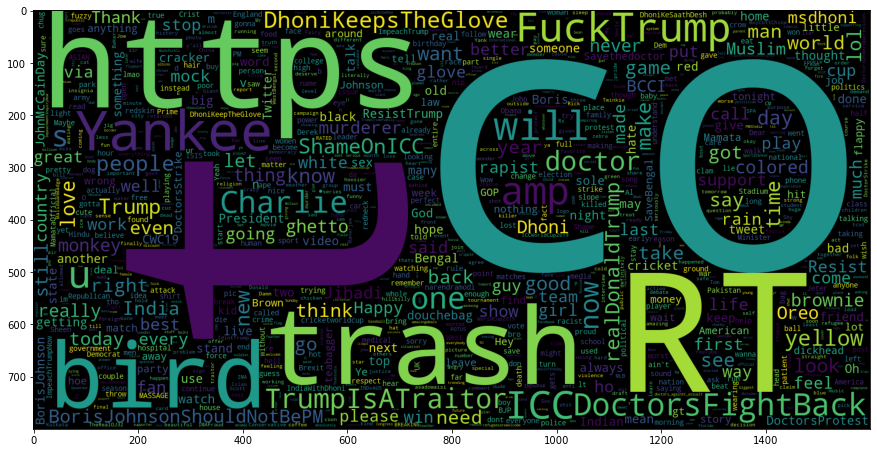

In [97]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(not_hate['text']))
plt.imshow(wc)

In [98]:
train.head()

text  label
0             It was nice of you to unfollow me, fag      1
1  @gCan28 @JeremyWGR \n\nAnd then everyone bitch...      1
2  Hi @BorisJohnson, what a coincidence, the majo...      1
3  RT @GreatNegrodamus: Lmfaoooooooooo trash ass ...      1
4                 Smile at the bitches who hate you.      1

In [99]:
def preprocess(tweet):
    result = re.sub(r'(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweet)
    result = re.sub(r'(@[A-Za-z0-9-_]+)', '', result)
    result = re.sub(r'http\S+', '', result)
    result = re.sub(r'bit.ly/\S+', '', result) 
    result = re.sub(r'&[\S]+?;', '', result)
    result = re.sub(r'#', ' ', result)
    result = re.sub(r'[^\w\s]', r'', result)    
    result = re.sub(r'\w*\d\w*', r'', result)
    result = re.sub(r'\s\s+', ' ', result)
    result = re.sub(r'(\A\s+|\s+\Z)', '', result)
    result = tokenize(result)
    return result 

def lemmatize(token):
    return WordNetLemmatizer().lemmatize(token, pos='v')

def tokenize(tweet):
    result = []
    for token in gensim.utils.simple_preprocess(tweet):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 2:  # drops stopwords and words with <3 characters
            result.append(lemmatize(token))
    result = ' '.join(result)
    return result

In [100]:
import nltk
#nltk.download()

train_processed = train.text.apply(lambda x: preprocess(x))
train_processed.head()

0                                    nice unfollow fag
1            bitch anyways guy win fan run revis prime
2    coincidence majority scottish people think sel...
3    lmfaoooooooooo trash ass falcants lmfaoooooooo...
4                                     smile bitch hate
Name: text, dtype: object

In [101]:
valid_processed = valid.text.apply(lambda x: preprocess(x))
valid_processed.head()

0                                       aint bitch doe
1                     sit pretty make bitch mad pretty
2    chase bread hoe cause meet dollar aint like facts
3    meet lil bitch wit long mufucka letter den ten...
4                      hoe pick like dandelions pickme
Name: text, dtype: object

In [102]:
def aps(X, y, model):
    probs = model.decision_function(X)
    return average_precision_score(y, probs)

def auc(X, y, model):
    probs = model.decision_function(X) 
    return roc_auc_score(y, probs)

def get_metrics(X, y, y_pred, model):
    acc = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    rec = recall_score(y, y_pred)
    prec = precision_score(y, y_pred)
    rocauc = auc(X, y, model)
    prauc = aps(X, y, model)
    
    print('Accuracy: ', acc)
    print('F1: ', f1)
    print('Recall: ', rec)
    print('Precision: ', prec)
    print('ROC-AUC: ', rocauc)
    print('PR-AUC: ', prauc)

def get_confusion(y, y_pred):
    cnf = confusion_matrix(y, y_pred)
    group_names = ['TN','FP','FN','TP']
    group_counts = ['{0:0.0f}'.format(value) for value in cnf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cnf.flatten()/np.sum(cnf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    fig, ax = plt.subplots(figsize=(4,4))
    sns.heatmap(cnf, annot=labels, fmt='', cmap='Blues', annot_kws={'size':14}, cbar=False, xticklabels=False, yticklabels=False)

In [103]:
X_tr = train_processed.values
X_val = valid_processed.values
y_tr = train.label.values
y_val = valid.label.values

vec = TfidfVectorizer()
tfidf_tr = vec.fit_transform(X_tr)
tfidf_val = vec.transform(X_val)

In [104]:
pickle.dump(vec, open("vec.pickle", "wb"))

In [105]:
clf = LogisticRegression(C=10, penalty='l2', solver='lbfgs').fit(tfidf_tr, y_tr)
y_pred = clf.predict(tfidf_val)
get_metrics(tfidf_val, y_val, y_pred, clf)

Accuracy:  0.941033434650456
F1:  0.9614226464405431
Recall:  0.9551817566041996
Precision:  0.9677456250714858
ROC-AUC:  0.9806736199033079
PR-AUC:  0.9945101166952914


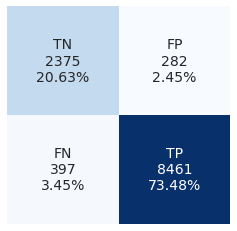

In [106]:
get_confusion(y_val, y_pred)

In [107]:
pickle.dump(clf, open("clf.pickle", "wb"))